In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import os
import time
import pickle

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

sns.set(font_scale=1.4)
sns.set_style("whitegrid")

In [ ]:
SELECT financialsALL.BvD, `consolidationCode`, `operatingRevenue`, `PLbeforeTax`, `Taxation`, `PLafterTax`, `deferredTaxes`, fixedAssets, tangibleFixedAssets,numberEmployees,loans,retainedEarnings
FROM `financialsALL`
WHERE year = 2016
INTO OUTFILE '/datastore0/mysql/tmp/macro_2018.csv' FIELDS TERMINATED BY '\t' ENCLOSED BY '' LINES TERMINATED BY '\n'

In [4]:
!cp /datastore0/mysql/tmp/macro_2018.csv ./data/macro_2018.csv

In [3]:
#load guos
path = "/datastore/shared_public/process_orbis_data/data/2017_12/cleaned/ownership/"
guos = sorted(['20180416_guos_2016.csv'])

d_guo = dict()
for guo in guos:
    with open(path+guo) as f:
        for line in f:
            splits =  line.strip().split()
            d_guo[splits[1]] = splits[-1]

    

In [9]:
#Read file
names = ["BvD", "consolidationCode", "operatingRevenue", "PLbeforeTax", "Taxation", "PLafterTax", "deferredTaxes",  "fixedAssets", "tangibleFixedAssets","numberEmployees","loans","retainedEarnings"]
macro_data = pd.read_csv("./data/macro_2018.csv",sep="\t",names=names,na_values=["\\N"])

#add guo
macro_data["guo"] = macro_data["BvD"].apply(lambda x: d_guo[x] if d_guo.get(x) is not None else x)

In [18]:
fields = ["operatingRevenue","PLbeforeTax","Taxation","PLafterTax","deferredTaxes","fixedAssets","tangibleFixedAssets","numberEmployees","loans","retainedEarnings"]

In [224]:
#all_coverage = []
for guo,data in macro_data.groupby("guo"):
    if guo in studied:
        continue
    if len(data)>10:
        cov = (data.loc[data["consolidationCode"].str[0]!="C",fields].sum()/
                data.loc[data["consolidationCode"].str[0]=="C",fields].max()).reset_index()
        cov2 = data.loc[data["consolidationCode"].str[0]=="C",fields].max().reset_index()
        cov.columns = ["field","coverage"]
        cov2.columns = ["field","total"]
        cov = pd.merge(cov,cov2)
        cov["company"] = guo
        all_coverage.append(cov)

In [234]:
len(all_coverage)

19473

In [225]:
ac = pd.concat(all_coverage).dropna().drop_duplicates()
ac.loc[(ac["coverage"]<0)|(ac["coverage"]>1),"coverage"] = 0
ac.head(10)

,field,coverage,total,company
0,operatingRevenue,0.217206,252741566.0,ADFEB32845
1,PLbeforeTax,0.042470,66279702.0,ADFEB32845
2,Taxation,0.000000,52705.0,ADFEB32845
3,PLafterTax,0.125967,68567099.0,ADFEB32845
5,fixedAssets,0.033766,327369740.0,ADFEB32845
0,operatingRevenue,0.493333,104785053.0,AE*901727278
1,PLbeforeTax,0.948808,6787375.0,AE*901727278
2,Taxation,0.204984,1776032.0,AE*901727278
3,PLafterTax,0.000000,5011343.0,AE*901727278
5,fixedAssets,0.000000,61328836.0,AE*901727278


In [226]:
means = ac.groupby("field").mean()
means

,coverage,total
field,,
PLafterTax,0.172085,2.176150e+08
PLbeforeTax,0.186131,2.895053e+08
Taxation,0.258738,7.604080e+07
deferredTaxes,0.040624,2.301970e+08
fixedAssets,0.150805,3.792623e+09
loans,0.056779,5.967200e+08
numberEmployees,0.350063,9.825319e+03
operatingRevenue,0.269279,3.023670e+09
retainedEarnings,0.047759,2.049980e+09


In [227]:
def weighted_mean(x,df):
    null = ~np.isnan(x)
    if np.sum(null) == 0:
        return np.NaN
    try:
        return np.average(x[null], weights=df.loc[x.index, "total"].values[null])
    except:#fails if weights are zero
        return np.NaN

In [228]:
x = ac.loc[ac["field"] == "PLbeforeTax"]
np.sum(x["coverage"]*x["total"])/np.sum(x["total"])

0.22371626520315166

In [229]:
dict_weighted = dict()
options = ["PLbeforeTax","fixedAssets","operatingRevenue","Taxation","numberEmployees"]
for o in options:
    data = ac.loc[ac["field"]==o]
    print(o,np.sum(data["coverage"]*data["total"]/np.sum(data["total"])))
    dict_weighted[o] = 100*np.sum(data["coverage"]*data["total"]/np.sum(data["total"]))
data_ac = ac.loc[ac["field"].isin(options)]

PLbeforeTax 0.22371626520315163
fixedAssets 0.20609934593504786
operatingRevenue 0.28580220897444286
Taxation 0.2637228107848517
numberEmployees 0.3174303904681481


In [230]:
data_ac["coverage"] *= 100

/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


/opt/anaconda/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


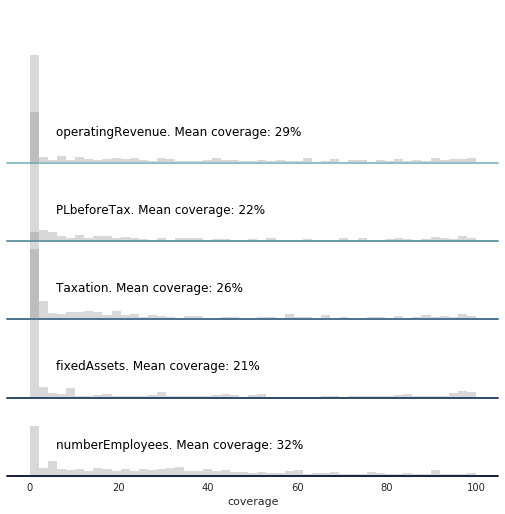

In [235]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


# Initialize the FacetGrid object
pal = sns.cubehelix_palette(5, rot=-.25, light=.7)
g = sns.FacetGrid(data_ac, row="field", hue="field", aspect=5,size=1.5, palette=pal)


# Define and use a simple function to label the plot in axes coordinates
def hist2(x, clip_on,bins,alpha,color,label):
    ax = plt.gca()
    weights = data_ac.loc[data_ac["field"]==label,"total"]
    ax.hist(x,normed=True,clip_on=clip_on,bins=bins,alpha=alpha,color=color,weights=weights)

    
    
# Draw the densities in a few steps
g.map(hist2, "coverage",clip_on=False,bins=np.linspace(0,100,50),alpha=0.3,color="gray")#, shade=True, alpha=1, lw=1.5, bw=.2)
#g.map(plt.hist, "coverage",clip_on=False,bins=np.linspace(0,100,50),alpha=0.3,color="gray",normed=True)#, shade=True, alpha=1, lw=1.5, bw=.2)
#g.map(sns.kdeplot, "coverage2",weights=, clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0.1, .2, "{}. Mean coverage: {:2.0f}%".format(label,dict_weighted[label] ),#100*means.loc[mean].values[0]),
    #ax.text(0.1, .2, "{}. Mean coverage: {:2.0f}%".format(label,100*means.loc[label].values[0]),
            color="k",
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "coverage")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

/opt/anaconda/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Number of statistics')

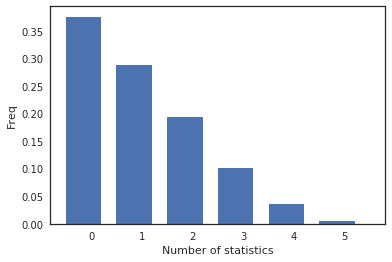

In [236]:
values = ac.loc[ac["field"].isin(set(options))].groupby("company").apply(lambda x: np.sum(x["coverage"]>0.5))
plt.hist(values,bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5],width=0.7,normed=True)
plt.ylabel("Freq")
plt.xlabel("Number of statistics")